In [1]:
import os
import sys
import numpy as np
import pandas as pd
# Root directory of the project
ROOT_DIR = '/home/users/sowmyak/ResidualDetectron'
# Directory to save logs and trained model
MODEL_DIR = '/scratch/users/sowmyak/resid/logs'
# path to images
DATA_PATH = '/scratch/users/sowmyak/resid/results'
CODE_PATH = '/home/users/sowmyak/ResidualDetectron/scripts'
sys.path.append(CODE_PATH)
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
# Change this for differnt models
import train15_6 as train
from train15_6 import InputConfig
import mrcnn.model as modellib
# import mrcnn.model5 as modellib
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

import scarlet
import scarlet.display

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
MODEL_PATH = '/scratch/users/sowmyak/resid/logs/resid15_620181109T1118/mask_rcnn_resid15_6_0040.h5'

/home/users/sowmyak/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

def get_ax(rows=1, cols=1, size=5):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class InferenceConfig(InputConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

dataset_val = train.ShapesDataset()
dataset_val.load_data(training=False)
dataset_val.prepare()
inference_config = InferenceConfig()


(4692, 120, 120, 12)
true samples:3692, false samples:1000
Loaded 4692 blends


In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=inference_config)
print("Loading weights from ", MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)

Loading weights from  /scratch/users/sowmyak/resid/logs/resid15_620181109T1118/mask_rcnn_resid15_6_0040.h5
Re-starting from epoch 40


<IPython.core.display.Javascript object>


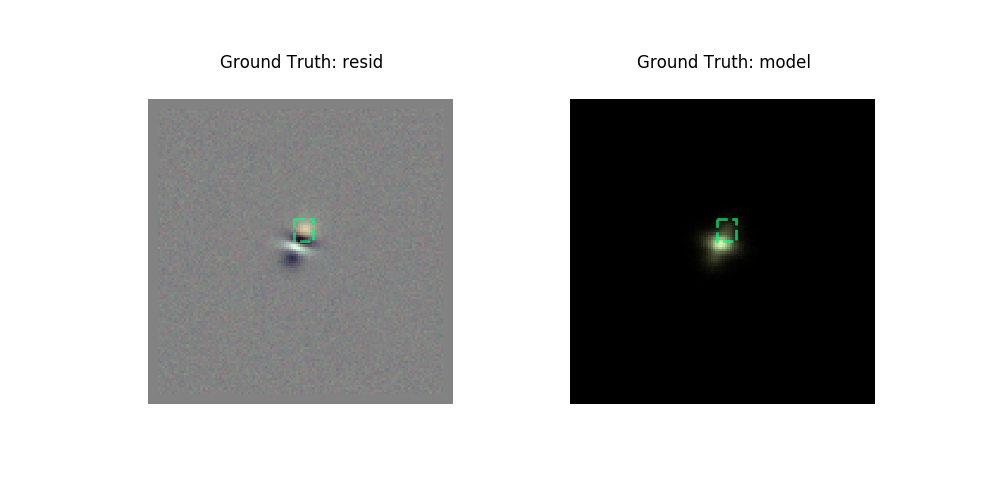

Input Image              shape: (128, 128, 12)        min:  -22.08251  max:   21.09261  float64


In [4]:
ax = get_ax(cols=2)
image_id = 1990  # np.random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
results1 = model.detect([image], verbose=0)
log("Input Image", image)
visualize.display_instances(image, gt_bbox, gt_class_id, 
                            dataset_val.class_names, None, ax=ax[0],
                            title="Ground Truth: resid", colors=['#00FF7F'])

#ax = get_ax(1)
flip = np.concatenate((image[:,:,6:12], image[:,:,0:6]), axis=2)
visualize.display_instances(flip, gt_bbox, gt_class_id, 
                            dataset_val.class_names, None, ax=ax[1],
                            title="Ground Truth: model", colors=['#00FF7F'])


# Mask R-CNN

Use Resnet101 architecture as backbone that generates proposal regions. Each proposed region is then passed through the head layers to perform classification + bbox prediction + segmentation.
![](mrcnn_figures/mrcnn.png "MRCNN architecture")

ResidDetectron uses only the calssification and bpunding box prediction in the head layer.


## Anchors

#### Issues:
1. Generating a variable-length list of bounding boxes. NN need fixed number of inputs and output.
2. Fixed grids won't works as object might lie over multiple grids or grids contain multiple objects

#### Solution: Anchor boxes

Instead of having to detect where objects are, we model the problem into two parts. For every anchor, we ask:
1. Does this anchor contain a relevant object?
1. How would we adjust this anchor to better fit the relevant object?

![](mrcnn_figures/anchor_box.png "Anchors")
<img src="mrcnn_figures/iou.png" width="250"/>

* If an anchor overlaps a GT box with IoU >= 0.7 then it's positive.
* If an anchor overlaps a GT box with IoU < 0.3 then it's negative.
* Neutral anchors are those that don't match the conditions above, and they don't influence the loss function.

Number of anchors selected for training is 256. If there are more than (255- #postive anchors) negative anchors, then randomly select (255- #postive anchors) negative anchors for training and assign the remaining as neutral anchors.







Count:  1364
Scales:  (4, 8, 16, 32, 64)
ratios:  [1]
Anchors per Cell:  1
Levels:  5


<IPython.core.display.Javascript object>


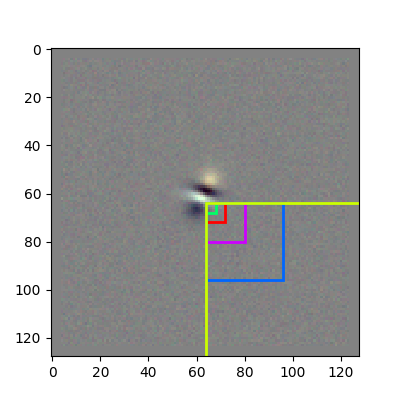

Level 0. Anchors:   1024  Feature map Shape: [32 32]
Level 1. Anchors:    256  Feature map Shape: [16 16]
Level 2. Anchors:     64  Feature map Shape: [8 8]
Level 3. Anchors:     16  Feature map Shape: [4 4]
Level 4. Anchors:      4  Feature map Shape: [2 2]


<IPython.core.display.Javascript object>


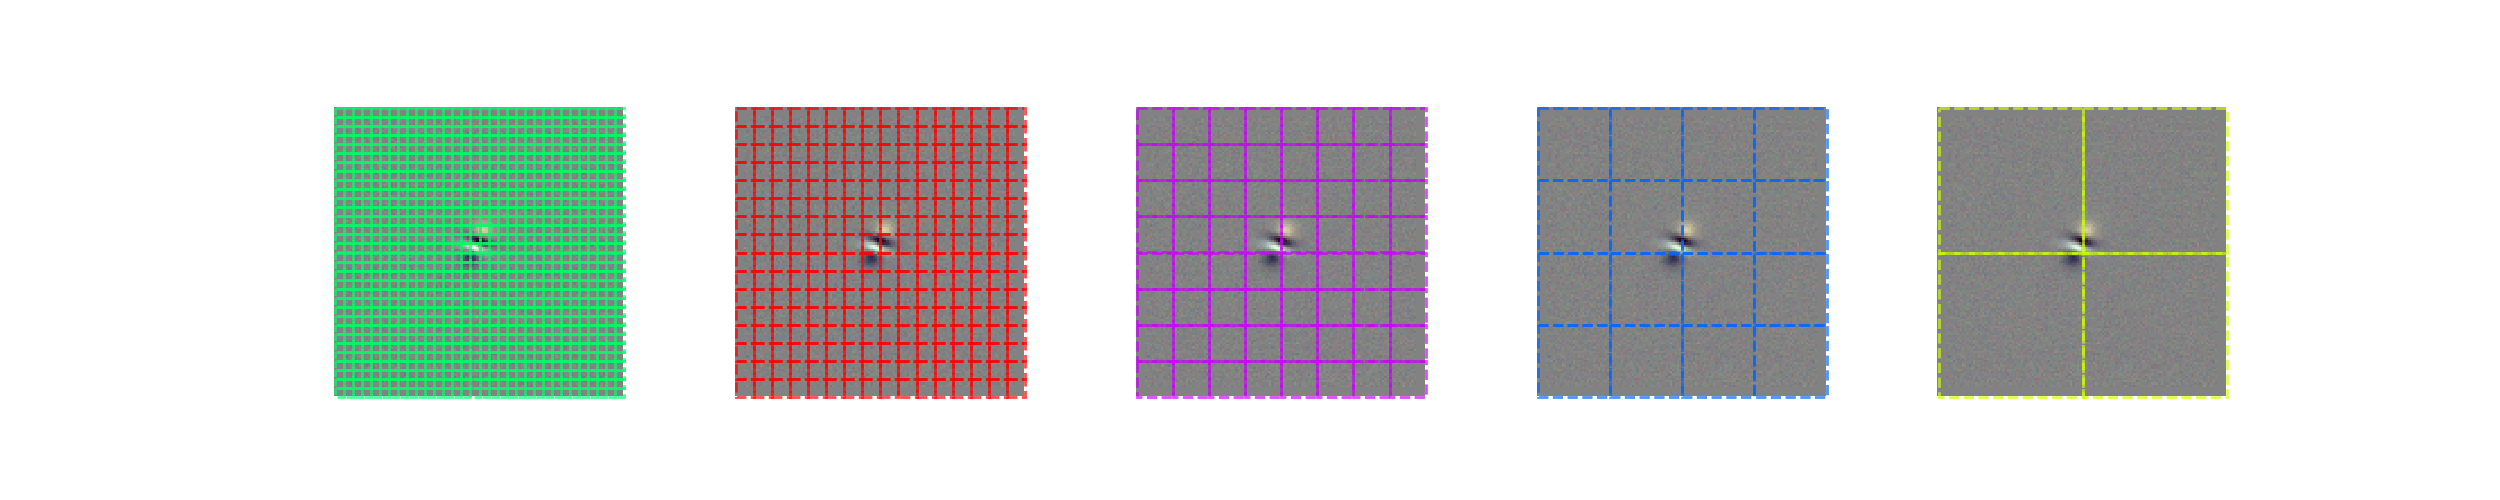

In [5]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(inference_config, inference_config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(inference_config.RPN_ANCHOR_SCALES, 
                                          inference_config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          inference_config.BACKBONE_STRIDES, 
                                          inference_config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(inference_config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", inference_config.RPN_ANCHOR_SCALES)
print("ratios: ", inference_config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // inference_config.RPN_ANCHOR_STRIDE**2)
fig, ax = plt.subplots(1, figsize=(4, 4))
rgb = scarlet.display.img_to_rgb(np.transpose(image[:, :, 1:4], axes=(2, 0, 1)))

ax.imshow(rgb)
levels = len(backbone_shapes)
colors = visualize.random_colors(levels)
for level in range(levels):
    
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / inference_config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / inference_config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

ax=get_ax(rows=1, cols=5)
for l in range(levels):
    anchors_l = utils.generate_anchors_no_spill(inference_config.RPN_ANCHOR_SCALES[l], [1], backbone_shapes[l],
                                              inference_config.BACKBONE_STRIDES[l], 
                                              inference_config.RPN_ANCHOR_STRIDE)
    visualize.display_instances(image, anchors_l, np.ones(len(anchors_l), dtype=int), 
                                dataset_val.class_names, None, ax=ax[l], colors=[colors[l]]*len(anchors_l))

target_rpn_match         shape: (1364,)               min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -3.75000  max:    3.12500  float64
positive_anchors         shape: (1, 4)                min:   48.00000  max:   72.00000  float64
negative_anchors         shape: (255, 4)              min:    0.00000  max:  128.00000  float64
neutral anchors          shape: (1108, 4)             min:    0.00000  max:  128.00000  float64
refined_anchors          shape: (1, 4)                min:   50.00000  max:   69.00000  float32


<IPython.core.display.Javascript object>


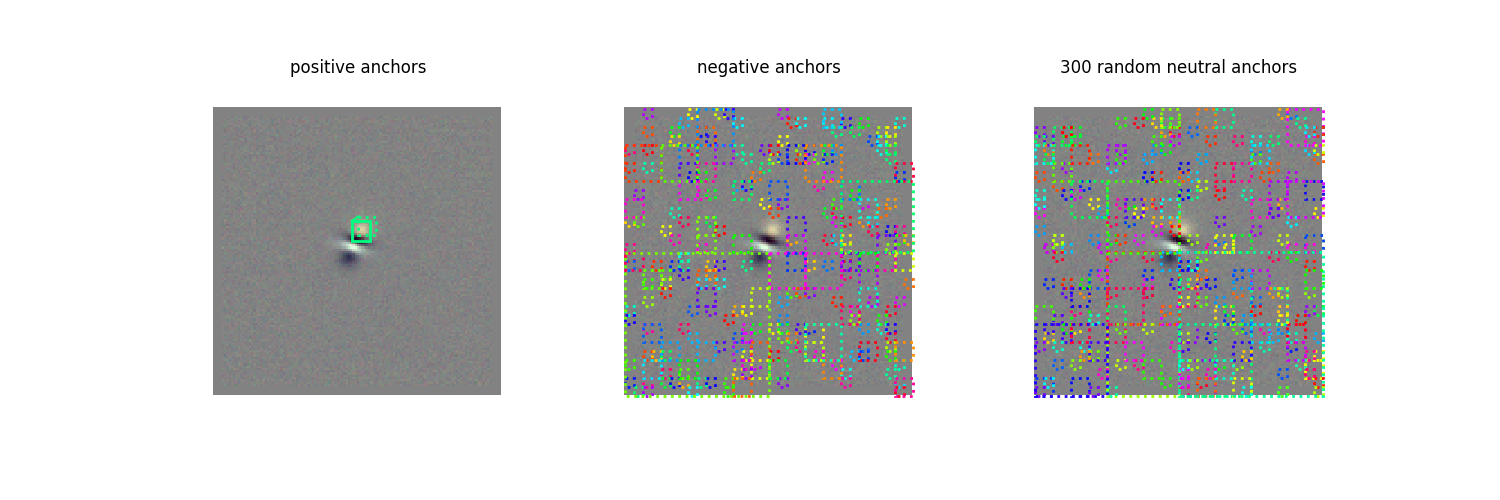

In [6]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

#visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax(), colors=['#00FF7F'])

ax=get_ax(cols=3)
        
# Show positive anchors
visualize.draw_boxes(image, boxes=positive_anchors, 
                     refined_boxes=refined_anchors, ax=ax[0], title='positive anchors',colors=['#00FF7F'])

# Show negative anchors
visualize.draw_boxes(image, boxes=negative_anchors, ax=ax[1], title='negative anchors')


# Show neutral anchors. They don't contribute to training.
pick = np.random.choice(range(len(neutral_anchors)), 300)
visualize.draw_boxes(image, boxes=neutral_anchors[pick], ax=ax[2], title='300 random neutral anchors')

## Feature Map

![](mrcnn_figures/feature_map.png "Feature Map")

Feature map has encoded all the information for the image while maintaining the location of the “things” it has encoded relative to the original image. 

### Feautre Pyramind Network

Detecting objects of different scales is made more efficieint using pyramidal hierarchy. Processing multi-scale images is time and memeory intensive. Higher performance is achieved using a pyramid of feature maps for detection.

FPN composes of a bottom-up and a top-down pathway. 
1. The bottom-up pathway is the usual convolutional network for feature extraction. As we go up, the spatial resolution decreases. With more high-level structures detected, the semantic value for each layer increases.
1. The top-down pathway constructs higher resolution layers from a semantic rich layer.

![](mrcnn_figures/fpn_basic.png "Feature Pyramid Network")


### FPN from Resnet architecture

![](mrcnn_figures/fpn_resid.png "FPN for Resnet Network")

As we go down the top-down path, we upsample the previous layer by 2 using nearest neighbors upsampling. We again apply a 1 × 1 convolution to the corresponding feature maps in the bottom-up pathway. Then we add them element-wise. We apply a 3 × 3 convolution again to output the next feature map layers for object detection. This filter reduces the aliasing effect of upsampling.

## Region Proposal Network (RPN) 
Two different outputs for each of the anchors.
1. Probability that an anchor is an object (p).
2. bounding box regression for adjusting the anchors to better fit the object it’s predicting.

<img src=mrcnn_figures/rpn_resid.png width="400"/>





rpn_class                shape: (1, 1364, 2)          min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 1364, 4)          min:    0.00000  max:    1.00000  float32
refined_anchors          shape: (1, 1364, 4)          min:   -1.12165  max:    1.98677  float32
refined_anchors_clipped  shape: (1, 1364, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (200,)                min:    0.00000  max:  205.00000  int32
proposals                shape: (1, 200, 4)           min:    0.00000  max:    1.00000  float32
Showing top 10 anchors before refinement


<IPython.core.display.Javascript object>


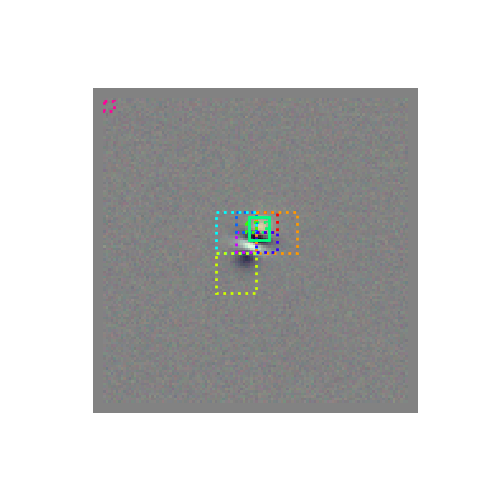

In [7]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])



# Show top anchors by score (before refinement)
limit = 10

print(f"Showing top {limit} anchors before refinement")
ax=get_ax()
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=ax)
visualize.draw_boxes(image, boxes=refined_anchors, refined_boxes=refined_anchors, ax=ax, colors=['#00FF7F'])

Showing top 10 anchors after refinement


<IPython.core.display.Javascript object>


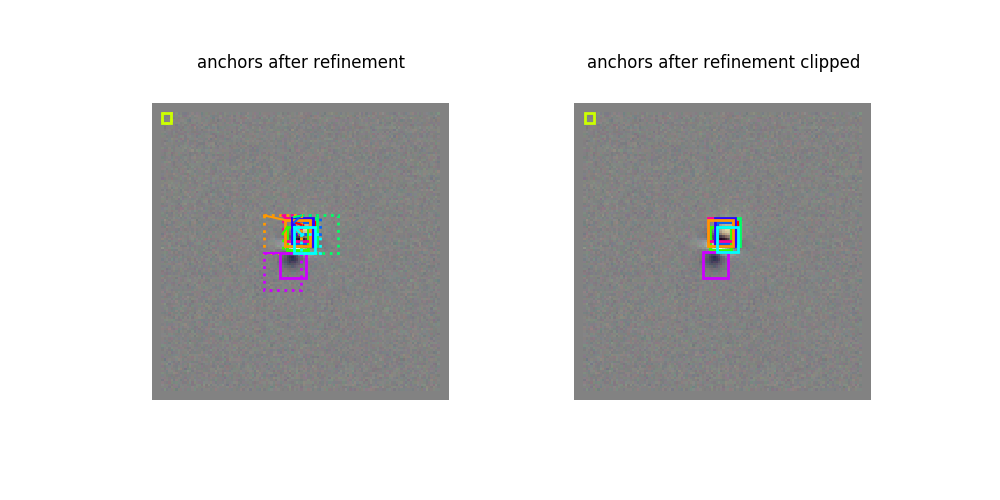

In [8]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 10

print(f"Showing top {limit} anchors after refinement")


pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
colors = visualize.random_colors(len(refined_anchors_clipped[:limit]))
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit],
                     ax=ax[0], colors=colors, title='anchors after refinement')
# visualize.draw_boxes(image, boxes=gt_bbox, refined_boxes=gt_bbox, ax=ax[0], colors=['#00FF7F'])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1], colors=colors,
                     title='anchors after refinement clipped')

#### Non Max Supression
Avoid duplicate proposals since anchors usually overlap, proposals end up also overlapping over the same object. 
1. Sort proposals by score
1. Iterate over the sorted list, discarding those proposals that have an IoU larger than some predefined threshold.


Showing top 10 of 200 anchors after NMS with threshold of 0.5


<IPython.core.display.Javascript object>


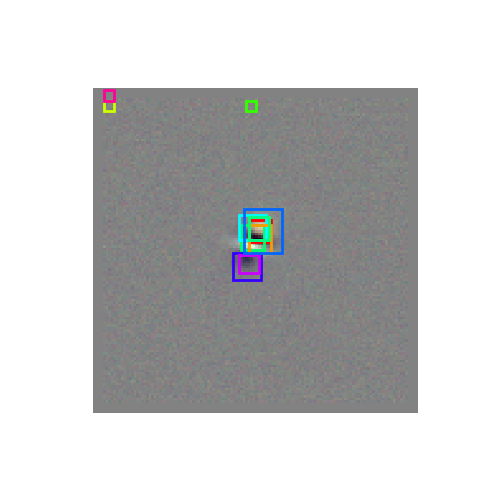

In [9]:
# Show refined anchors after non-max suppression
limit = 10
print(f"Showing top {limit} of {len(rpn['post_nms_anchor_ix'])} anchors after NMS with threshold of {inference_config.RPN_NMS_THRESHOLD}")
ax=get_ax()
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=ax)
visualize.draw_boxes(image, boxes=gt_bbox, refined_boxes=gt_bbox, ax=ax, colors=['#00FF7F'])

### Classification Bbox generation layers 

Selected RoIs from RPN are input to the classification & bbox prediction (+ segmentation) layers

* Computes bounding box for each class.
* Selects bbox for class with highest score (ignoring background)
![](mrcnn_figures/resid_head.png "ResidDetectron head")


proposals                shape: (1, 200, 4)           min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 200, 2)           min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 200, 2, 4)        min:   -4.96007  max:    3.20037  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
200 Valid proposals out of 200
5 Positive ROIs
[('BG', 195), ('object', 5)]


<IPython.core.display.Javascript object>


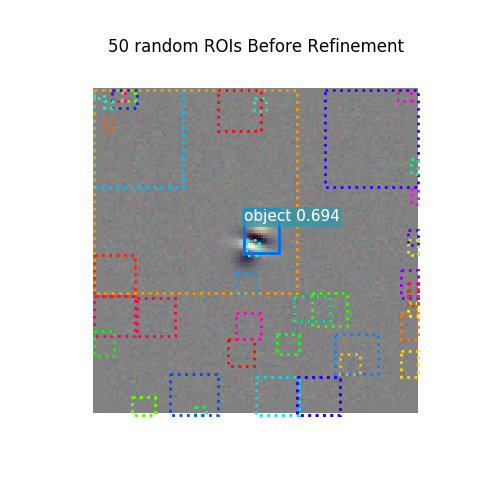

In [10]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])


# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = inference_config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_val.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 50
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title=f"{limit} random ROIs Before Refinement",
                     ax=get_ax())

roi_bbox_specific        shape: (200, 4)              min:   -3.38206  max:    3.20037  float32
refined_proposals        shape: (200, 4)              min:   -8.00000  max:  130.00000  int32


/home/users/sowmyak/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


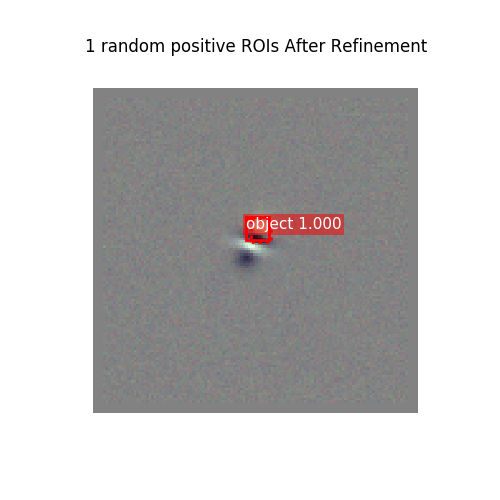

In [19]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * inference_config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 1
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title=f"{limit} random positive ROIs After Refinement",
                     ax=get_ax())

 Only positive: Keep 5 detections:
[0 2 3 5 7]
Remove boxes below 0.965 confidence. Keep 2:
[0 3]


<IPython.core.display.Javascript object>


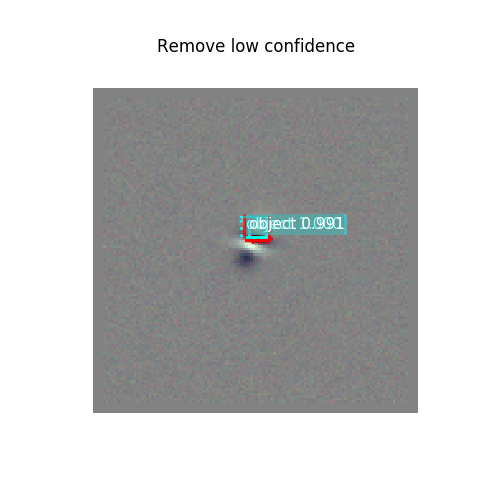

In [12]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print(" Only positive: Keep {} detections:\n{}".format(keep.shape[0], keep))


# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= inference_config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    inference_config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Remove low confidence",
    ax=get_ax())

object                : [0 3] -> [0]

Kept after per-class NMS with threshold0.3 : 1
[0]


<IPython.core.display.Javascript object>


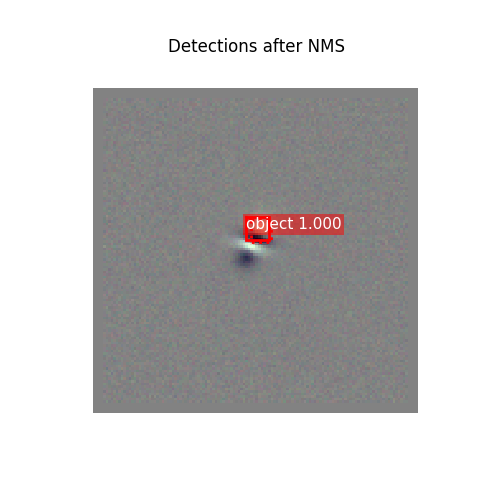

In [13]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            inference_config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_val.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS with threshold{} : {}\n{}".format(inference_config.DETECTION_NMS_THRESHOLD, keep.shape[0], keep))


# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

input_image              shape: (1, 128, 128, 12)     min:  -22.08251  max:   21.09262  float32
res2c_out                shape: (1, 32, 32, 256)      min:    0.00000  max:   23.48217  float32
res3d_out                shape: (1, 16, 16, 512)      min:    0.00000  max:   13.32462  float32
res4w_out                shape: (1, 8, 8, 1024)       min:    0.00000  max:    6.25060  float32
res5c_out                shape: (1, 4, 4, 2048)       min:    0.00000  max:    2.69907  float32
Input Image Activations


<IPython.core.display.Javascript object>


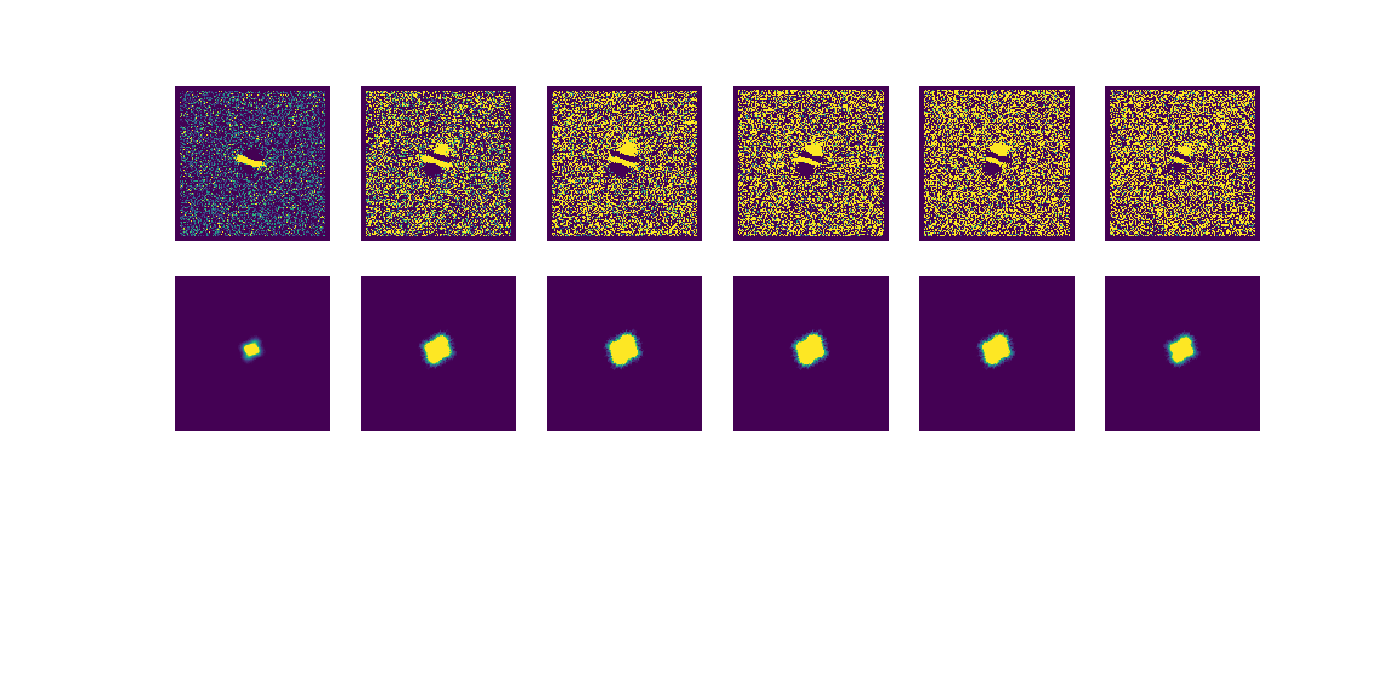

5, 95 percentile are:  -1.138925355672836 1.2080973386764526
Res2 Activations


<IPython.core.display.Javascript object>


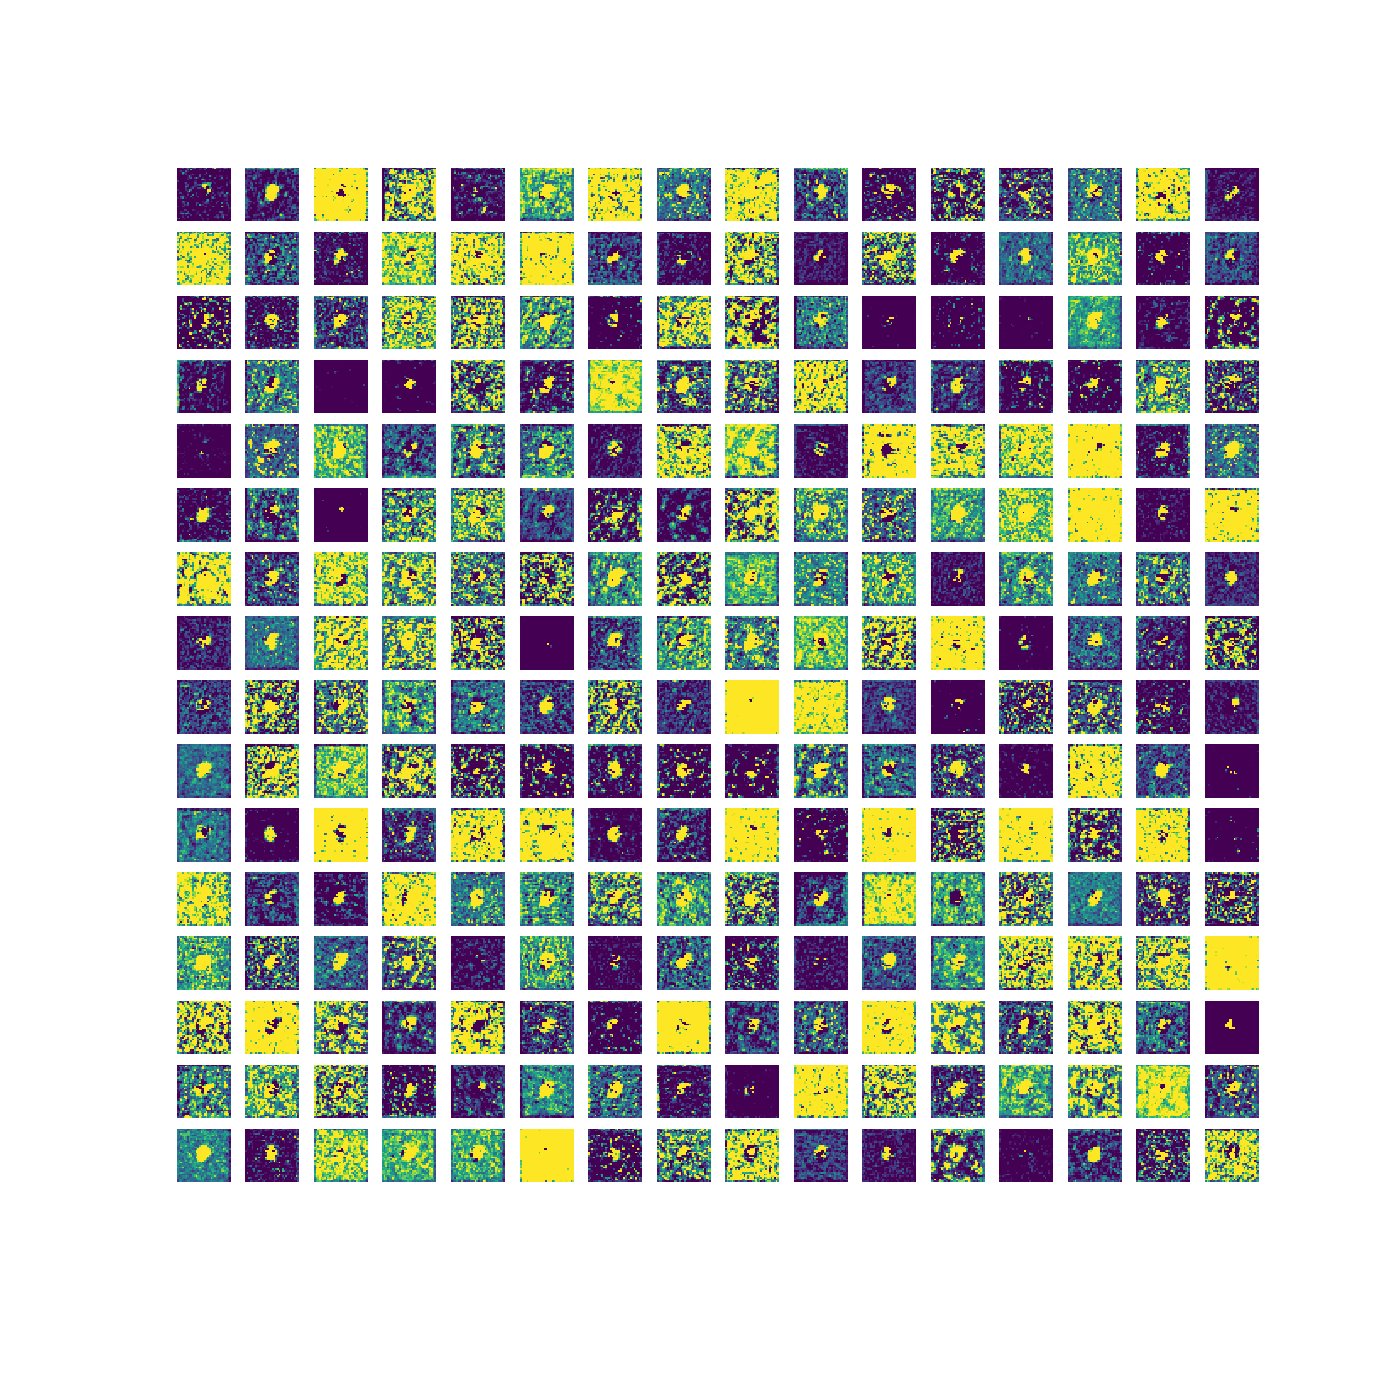

5, 95 percentile are:  0.0 0.9019279241561887
Res3 Activations


<IPython.core.display.Javascript object>


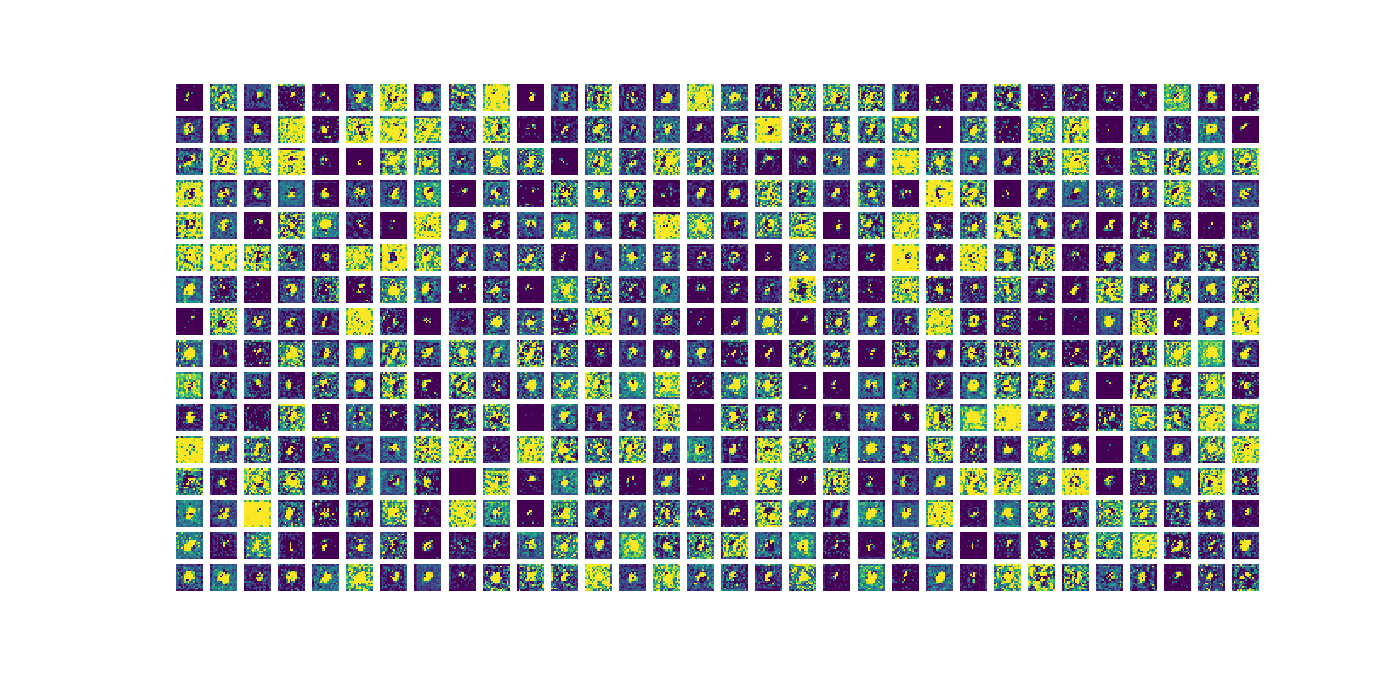

5, 95 percentile are:  0.0 0.6211949169635772
Res4 Activations


<IPython.core.display.Javascript object>


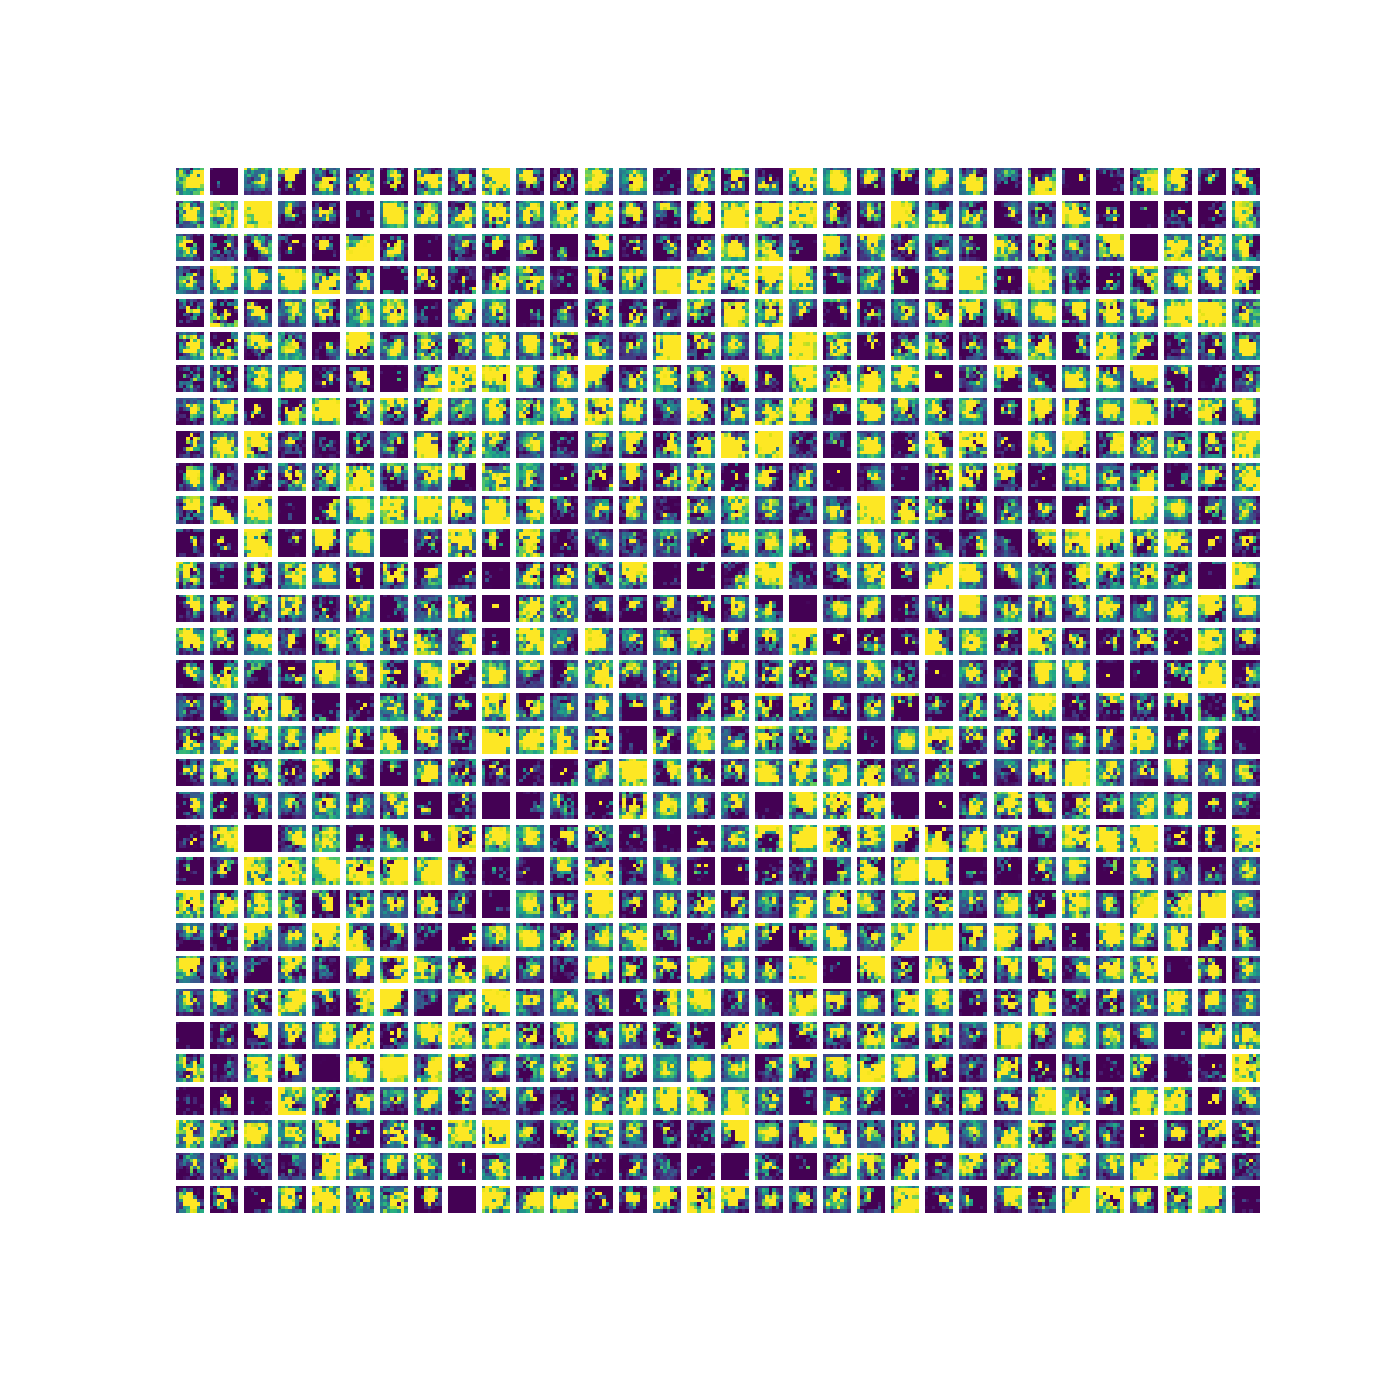

5, 95 percentile are:  0.0 0.8666284829378128
Res5 Activations


<IPython.core.display.Javascript object>


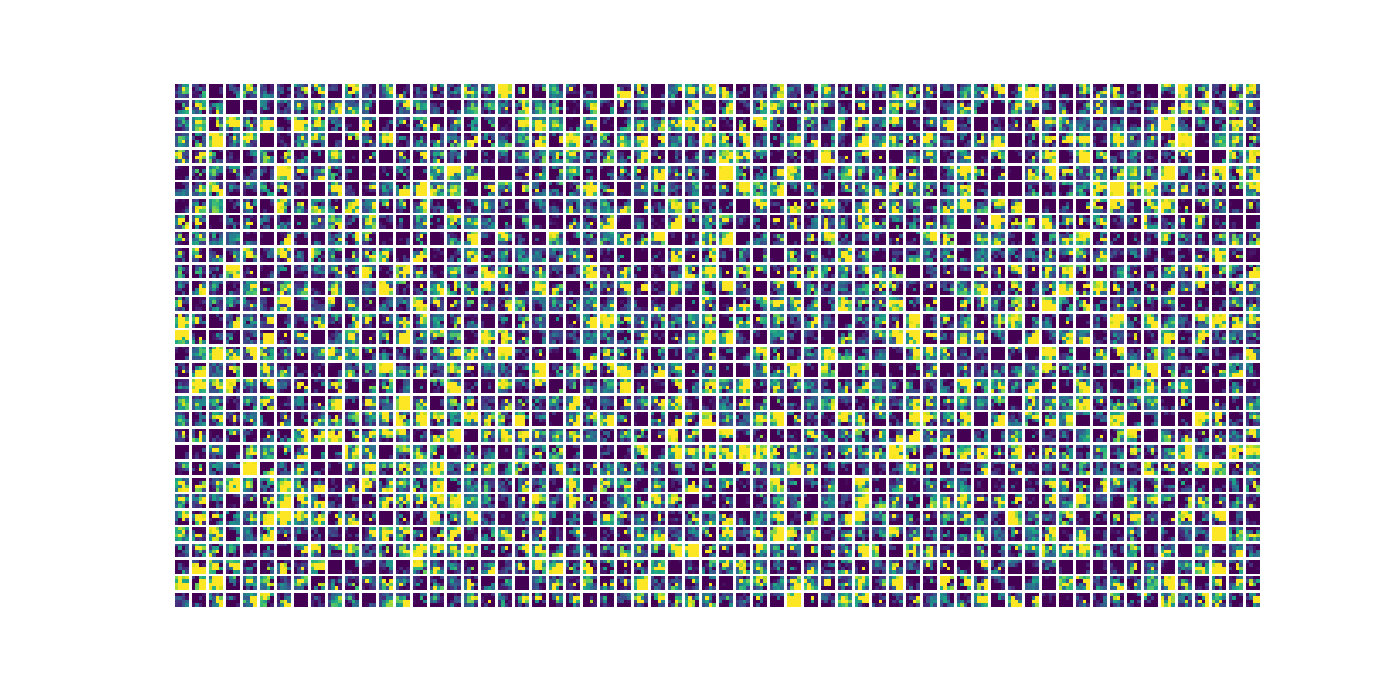

5, 95 percentile are:  0.0 0.5909804135560989


In [14]:
### Interanl Visualizations

# Activation Layers
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3d_out",          model.keras_model.get_layer("res3d_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("res5c_out",          model.keras_model.get_layer("res5c_out").output)
])


print("Input Image Activations")
display_images(np.transpose(activations["input_image"][0], [2, 0, 1]), cols=6, same_color=True,color_range=(0, 0.4))
print("Res2 Activations")
display_images(np.transpose(activations["res2c_out"][0], [2, 0, 1]), cols=16, same_color=True,color_range=(0, 0.4))
print("Res3 Activations")
display_images(np.transpose(activations["res3d_out"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(0, 0.4))
print("Res4 Activations")
display_images(np.transpose(activations["res4w_out"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(0, 0.4))
print("Res5 Activations")
display_images(np.transpose(activations["res5c_out"][0], [2, 0, 1]), cols=64, same_color=True,color_range=(0, 0.4))

fpn_p5                   shape: (1, 4, 4, 256)        min:   -2.09817  max:    2.67130  float32
fpn_p4                   shape: (1, 8, 8, 256)        min:   -3.09031  max:    3.11182  float32
fpn_p3                   shape: (1, 16, 16, 256)      min:   -7.24870  max:    7.79906  float32
fpn_p2                   shape: (1, 32, 32, 256)      min:  -15.75051  max:   13.56343  float32
fpn_p6                   shape: (1, 2, 2, 256)        min:   -1.88772  max:    2.46388  float32
P2 Activations


<IPython.core.display.Javascript object>


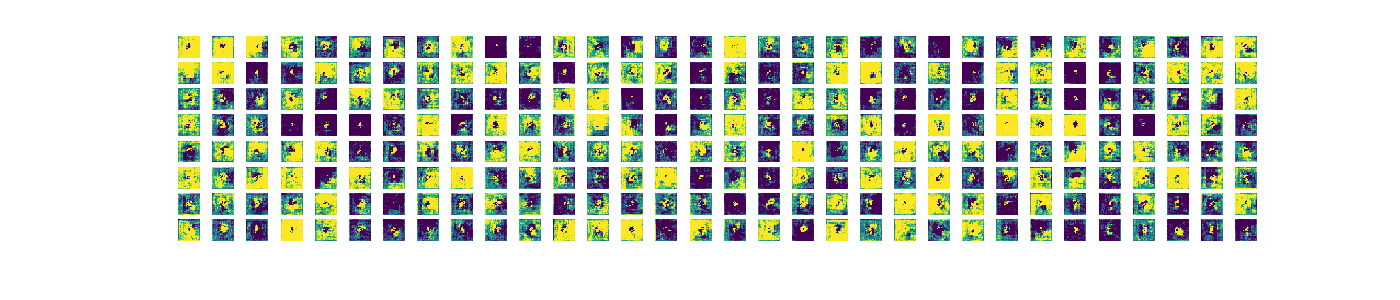

5, 95 percentile are:  -1.4602859914302824 1.4744115173816659
P3 Activations


<IPython.core.display.Javascript object>


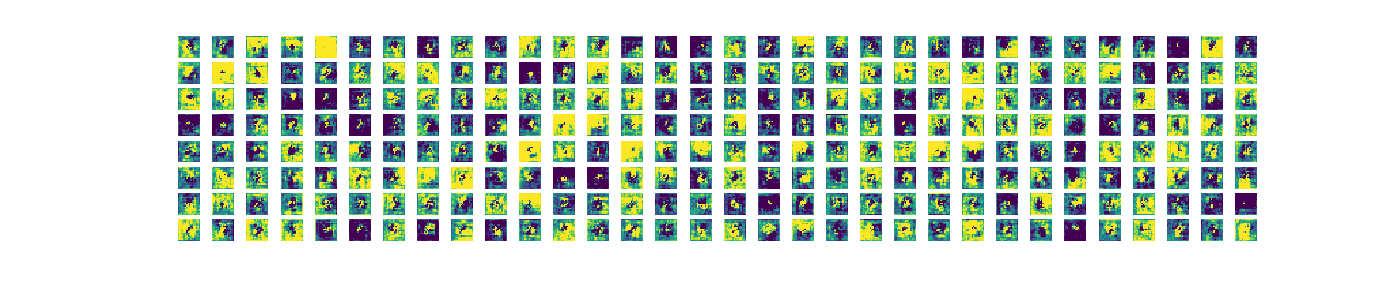

5, 95 percentile are:  -1.0875007212162018 1.0983204543590546
P4 Activations


<IPython.core.display.Javascript object>


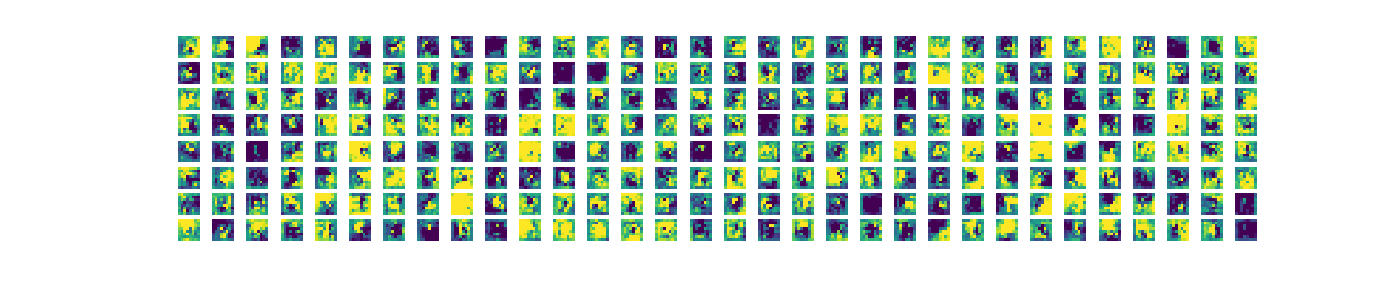

5, 95 percentile are:  -0.9550446063280105 1.0115900576114638
P5 Activations


<IPython.core.display.Javascript object>


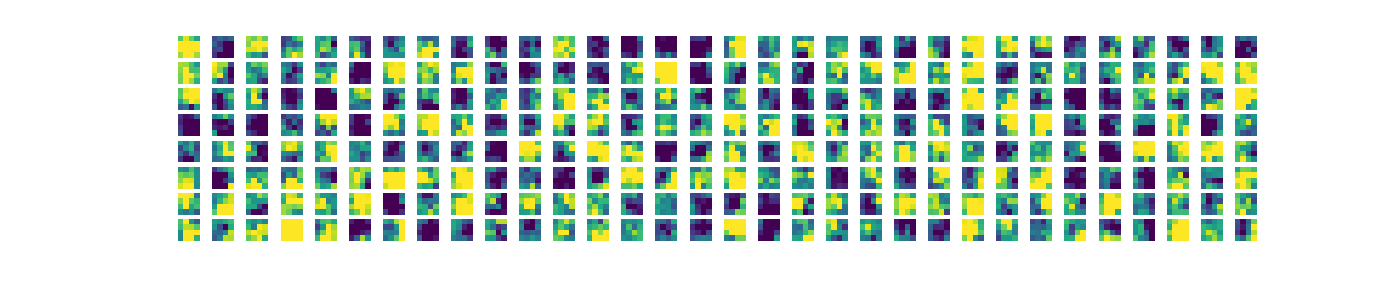

5, 95 percentile are:  -0.8786423355340958 0.9469608664512634
P6 Activations


/home/users/sowmyak/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


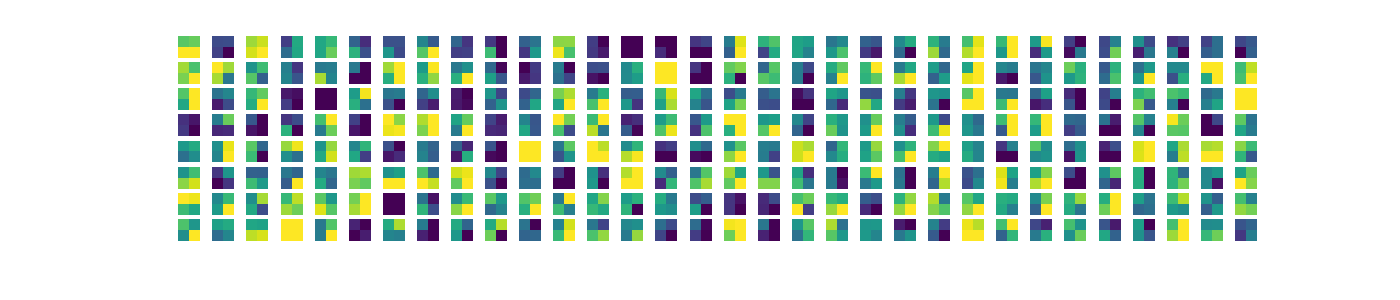

5, 95 percentile are:  -0.8329297393560409 0.8193820476531969


In [15]:
activations = model.run_graph([image], [
    ("fpn_p5",        model.keras_model.get_layer("fpn_p5").output),
    ("fpn_p4",           model.keras_model.get_layer("fpn_p4").output),
    ("fpn_p3",          model.keras_model.get_layer("fpn_p3").output),
    ("fpn_p2",          model.keras_model.get_layer("fpn_p2").output),
    ("fpn_p6",          model.keras_model.get_layer("fpn_p6").output)
])

print("P2 Activations")
display_images(np.transpose(activations["fpn_p2"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(-0.6, 0.6))
print("P3 Activations")
display_images(np.transpose(activations["fpn_p3"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(-0.6, 0.6))
print("P4 Activations")
display_images(np.transpose(activations["fpn_p4"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(-0.6, 0.6))
print("P5 Activations")
display_images(np.transpose(activations["fpn_p5"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(-0.6, 0.6))
print("P6 Activations")
display_images(np.transpose(activations["fpn_p6"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(-0.6, 0.6))

rpn_bbox                 shape: (1, 1364, 4)          min:  -12.15924  max:   20.46625  float32
rpn_class                shape: (1, 1364, 2)          min:    0.00000  max:    1.00000  float32
roi                      shape: (1, 200, 4)           min:    0.00000  max:    1.00000  float32


/home/users/sowmyak/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


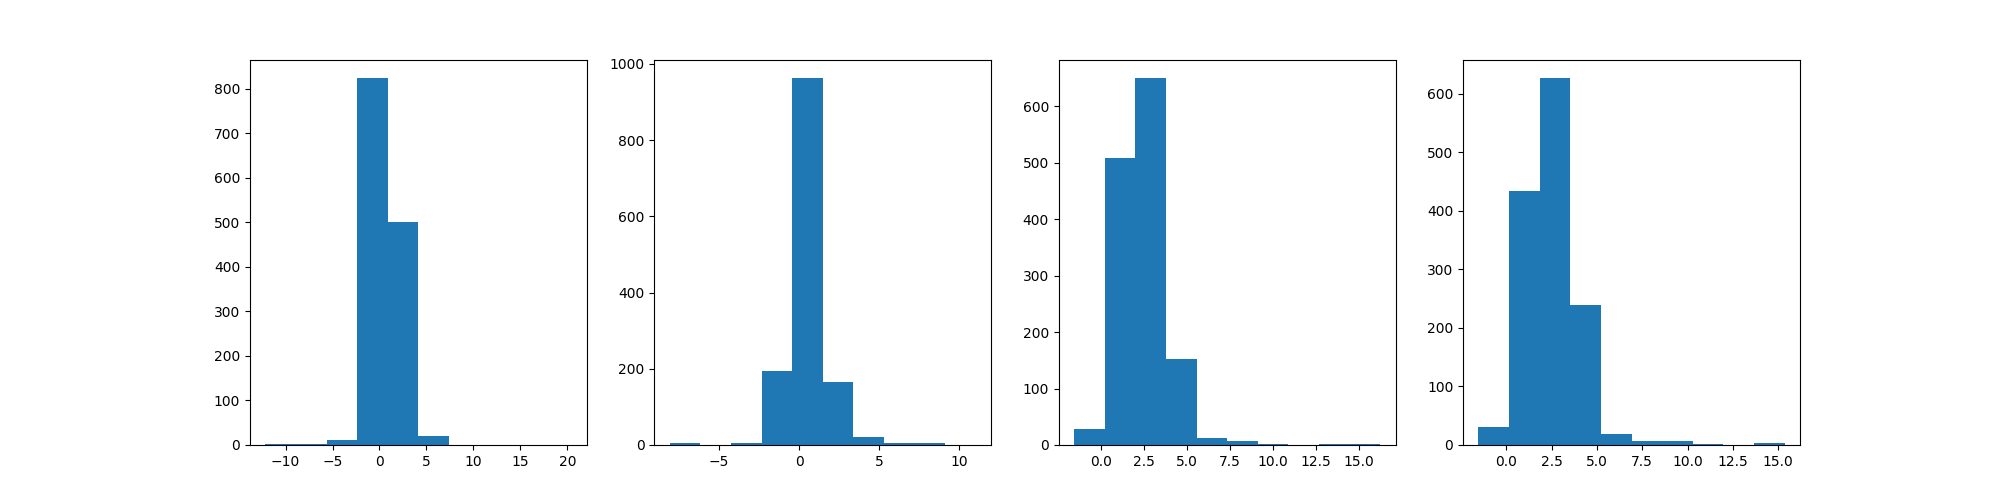

<IPython.core.display.Javascript object>


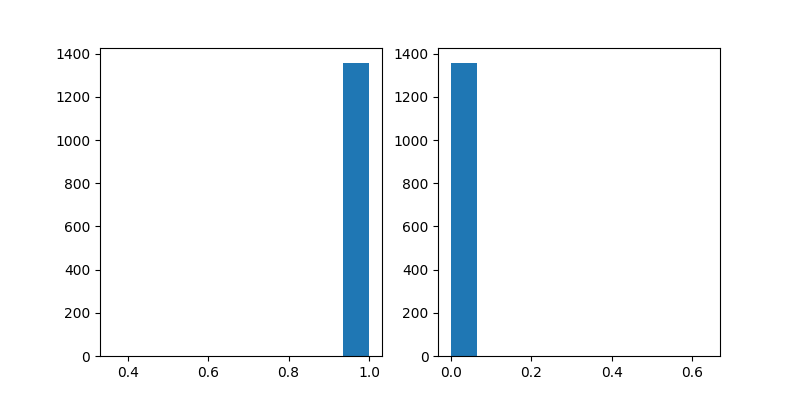

In [16]:
# Get activations of a few sample layers
activations2 = model.run_graph([image], [
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("rpn_class",           model.keras_model.get_layer("rpn_class").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

ax=get_ax(cols=4)
for i in range(activations2["rpn_bbox"].shape[-1]):
    
    ax[i].hist(activations2["rpn_bbox"][0,:,i])
ax=get_ax(cols=2, size=4)
for i in range(activations2["rpn_class"].shape[-1]):
    
    ax[i].hist(activations2["rpn_class"][0,:,i])

## Performance Metrics

Validation test comprised of 3688 undetected blends (two galaxy blends with only one source detected) + a control sample of 1000 objects where a single galaxy was modelled with scarlet.

* TN (true neagtive): Of the 1000 samples, number of times the network correctly did not detect an object
* TP (true positive): In 3688 blends images number of predictions made by the network that correspond to either or both of the galaxies. 
* FP (false positive): Network predicted sources for background. 
* False Negative: Of the 3688 samples, number of times the network did not identify the undetected source.

<img src="https://latex.codecogs.com/svg.latex?\Large&space;Precision=\frac{TP}{TP+FP}"/>
<img src="https://latex.codecogs.com/svg.latex?\Large&space;Recall=\frac{TP}{TP+FN}"/>
<img src="https://latex.codecogs.com/svg.latex?\Large&space;F-score=2\frac{precision*recall}{precision+recall}"/>
<img src="https://latex.codecogs.com/svg.latex?\Large&space;TNR(true\_negative\_rate)=\frac{TN}{TN+FP}"/>
<img src="https://latex.codecogs.com/svg.latex?\Large&space;NPV(negative\_prediction\_value)=\frac{TN}{TN+FN}"/>



In [43]:
DATA_PATH1 = '/scratch/users/sowmyak/resid/'
file_name = os.path.join(DATA_PATH1, 'results/resid15_6_metric.pd')

true_num = 3691
results = pd.read_csv(file_name)
false, = np.where(results['id'] > true_num)
true, = np.where(results['id'] <= true_num)
np.testing.assert_array_equal(len(np.unique(results['id'][false])) , 1000, 'negative samples not 1000')
TN = len(np.where(results['unrecog_blnd'][false] == 1)[0])
neg_fail, = np.where(results['unrecog_blnd'][false] != 1)
np.testing.assert_array_equal(len(np.unique(results['id'][false[neg_fail]])) + TN , 1000, 'negative samples not 1000')
pos_fail, = np.where(results['metric_score'][true] < 0)
FP = len(neg_fail) + len(pos_fail)
pos, = np.where(results['metric_score'][true]>0)
TP = np.sum(results['metric_score'][true][pos])
FN = len(np.where((results['metric_score'][true] == 0) &(results['roi_x1'][true] >20))[0])
np.testing.assert_array_less(3691, FN +TP +len(np.unique(results['id'][true[pos_fail]])), 'positive samples not 3691')
p = TP/ (TP+FP)
r = TP / (TP + FN)
f = 2 * (p *r)/ (p+r)
tnr = TN/ (TN + FP)
npv = TN/(TN+FN)
sel, = np.where((results['iter_recog'] ==1)&(results['roi_x1'][true] >20))
iou = np.mean(results['iou'][sel])
class_names = ('unrecog_blnd', 'iter_recog', 'iter_recog_other',
             'iter_recog_both', 'iter_spurious', 'iter_shred')
count={}
for clss in class_names:
    q, = np.where(results[clss] == 1)
    select = results['id'][q].astype(int)
    count[clss] = np.unique(select)
    print(clss, "predictions: ", len(count[clss]))
print("Total: ", np.sum([len(count[clss]) for clss in class_names]))


print(f"true negative = {TN}/1000")
print(f"precision = {p:.3f}, recall={r:.3f}, fscore={f:.3f}, true negative rate={tnr:.3f}, npv ={npv:.3f} ")
print(f"Mean IoU:{iou}")


unrecog_blnd predictions:  570
iter_recog predictions:  2881
iter_recog_other predictions:  97
iter_recog_both predictions:  242
iter_spurious predictions:  584
iter_shred predictions:  314
Total:  4688
true negative = 526/1000
precision = 0.755, recall=0.872, fscore=0.809, true negative rate=0.331 , npv =0.524 
Mean IoU:0.7312855235906954


<IPython.core.display.Javascript object>


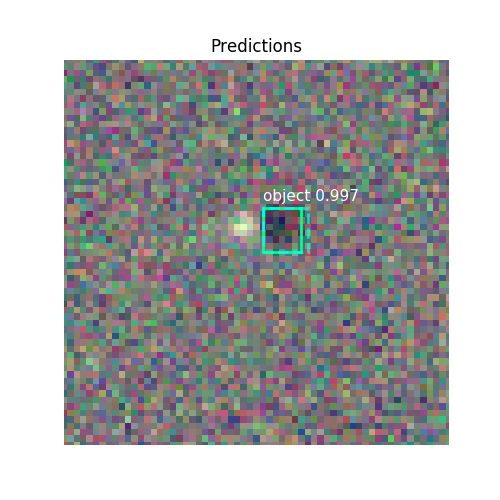

image ID: resid.1071 (1071) object


<IPython.core.display.Javascript object>


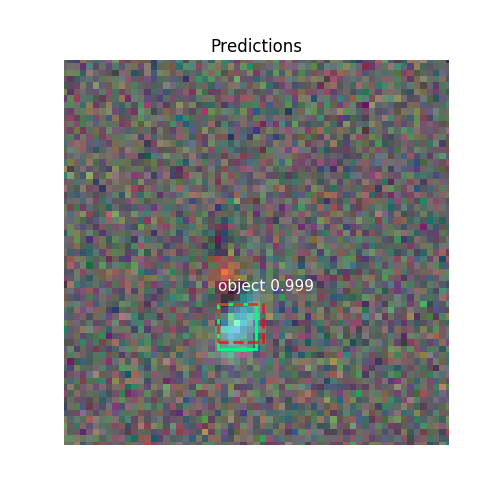

image ID: resid.2198 (2198) object


<IPython.core.display.Javascript object>


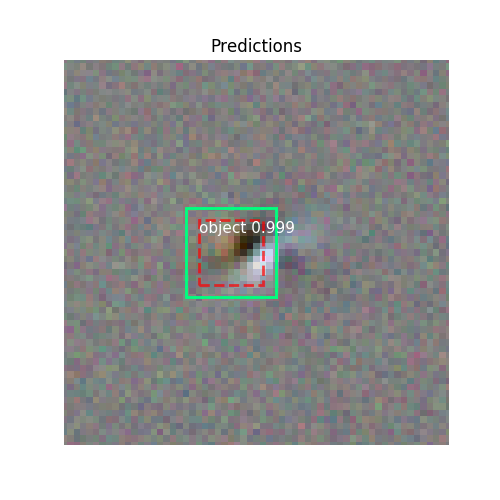

image ID: resid.1373 (1373) object


<IPython.core.display.Javascript object>


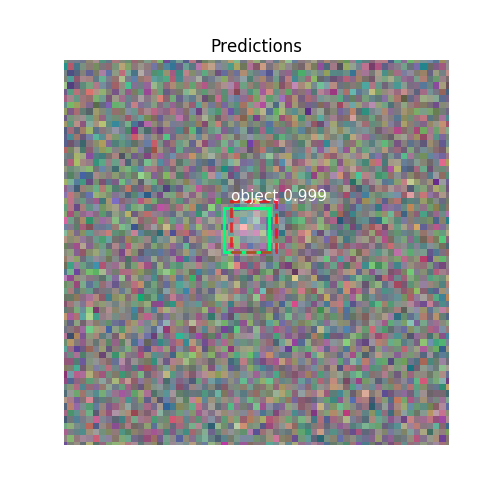

image ID: resid.2117 (2117) object


<IPython.core.display.Javascript object>


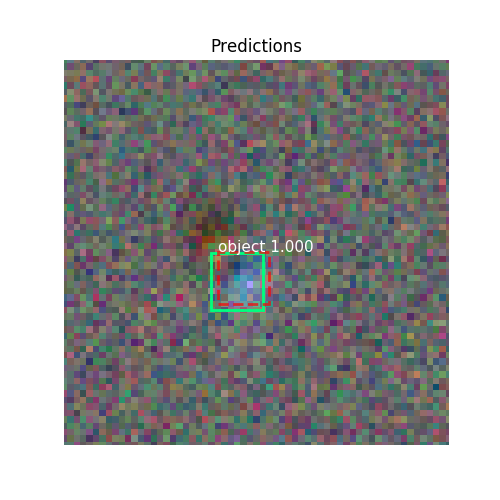

image ID: resid.253 (253) object


In [38]:
clss = 'iter_recog'
im_ids = np.random.choice(count[clss], 5)
for im_id in im_ids :
    ax = get_ax(1)
    image1, image_meta1, gt_class_id1, gt_bbox1 =\
        modellib.load_image_gt(dataset_val, inference_config, (im_id), use_mini_mask=False)
    info1 = dataset_val.image_info[im_id]
    results1 = model.detect([image1], verbose=0)
    r1 = results1[0]
    print("image ID: {}.{} ({}) {}".format(info1["source"], info1["id"], im_id, 
                                       dataset_val.image_reference(im_id)))
    visualize.draw_boxes(image1, boxes=gt_bbox1, refined_boxes=gt_bbox1, ax=ax, colors=['#00FF7F'])
    visualize.display_instances(image1, r1['rois'], r1['class_ids'], 
                                dataset_val.class_names, r1['scores'], ax=ax,
                                title="Predictions", limits=(34, 94))
    

<IPython.core.display.Javascript object>


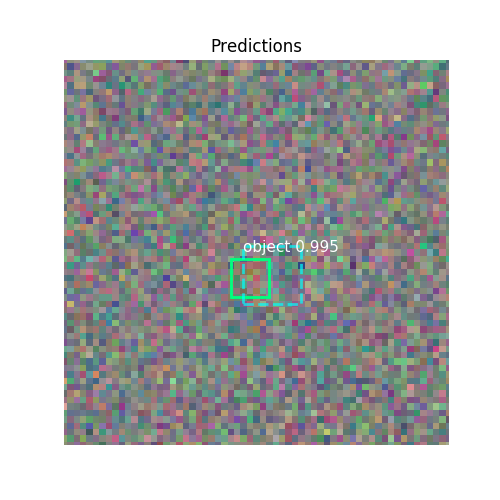

image ID: resid.1637 (1637) object


<IPython.core.display.Javascript object>


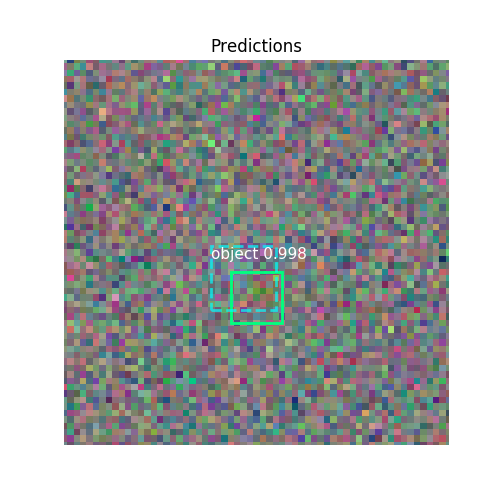

image ID: resid.2531 (2531) object


<IPython.core.display.Javascript object>


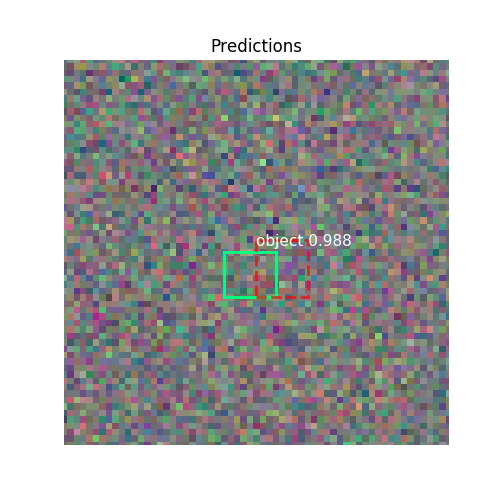

image ID: resid.1695 (1695) object


<IPython.core.display.Javascript object>


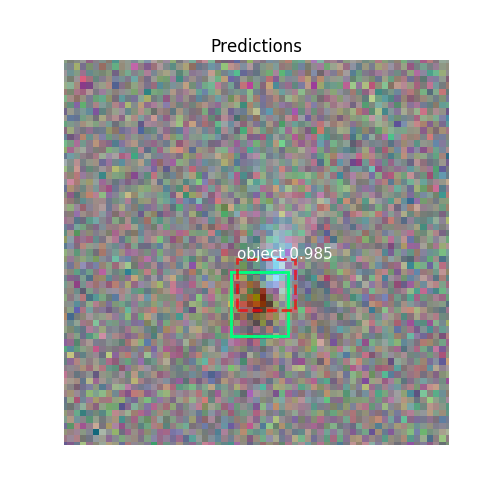

image ID: resid.3304 (3304) object


<IPython.core.display.Javascript object>


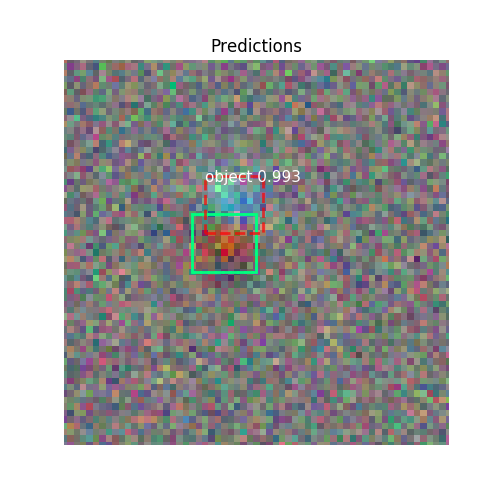

image ID: resid.29 (29) object


In [39]:
clss = 'iter_recog_other'
im_ids = np.random.choice(count[clss], 5)
for im_id in im_ids :
    ax = get_ax(1)
    image1, image_meta1, gt_class_id1, gt_bbox1 =\
        modellib.load_image_gt(dataset_val, inference_config, (im_id), use_mini_mask=False)
    info1 = dataset_val.image_info[im_id]
    results1 = model.detect([image1], verbose=0)
    r1 = results1[0]
    print("image ID: {}.{} ({}) {}".format(info1["source"], info1["id"], im_id, 
                                       dataset_val.image_reference(im_id)))
    visualize.draw_boxes(image1, boxes=gt_bbox1, refined_boxes=gt_bbox1, ax=ax, colors=['#00FF7F'])
    visualize.display_instances(image1, r1['rois'], r1['class_ids'], 
                                dataset_val.class_names, r1['scores'], ax=ax,
                                title="Predictions", limits=(34, 94))

<IPython.core.display.Javascript object>


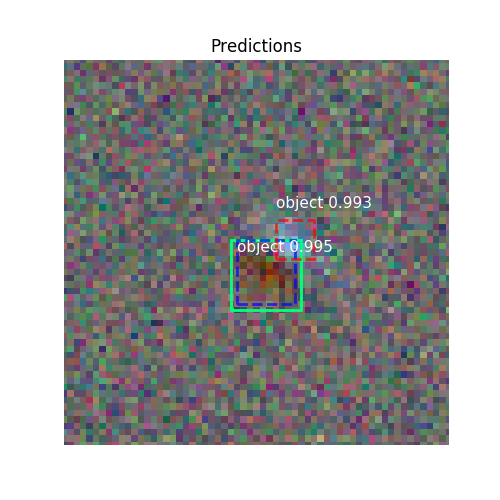

image ID: resid.2995 (2995) object


<IPython.core.display.Javascript object>


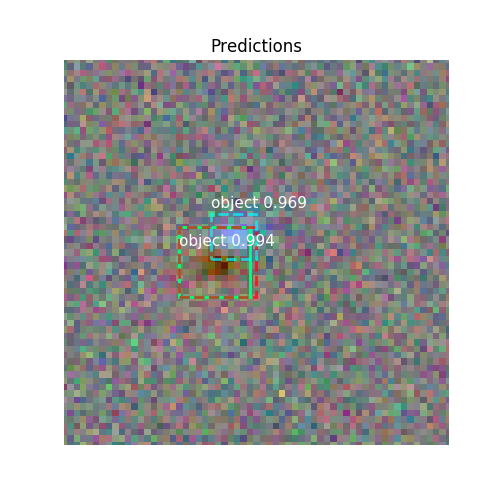

image ID: resid.3370 (3370) object


<IPython.core.display.Javascript object>


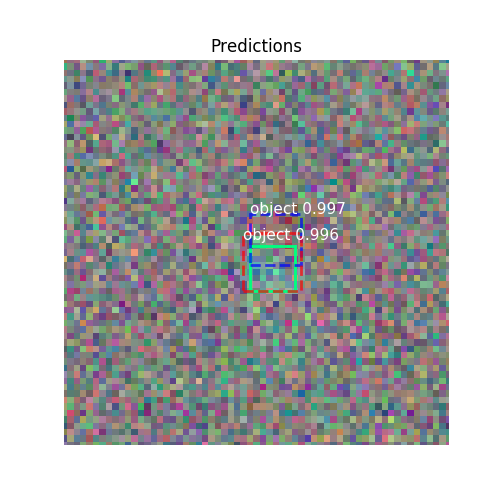

image ID: resid.1939 (1939) object


<IPython.core.display.Javascript object>


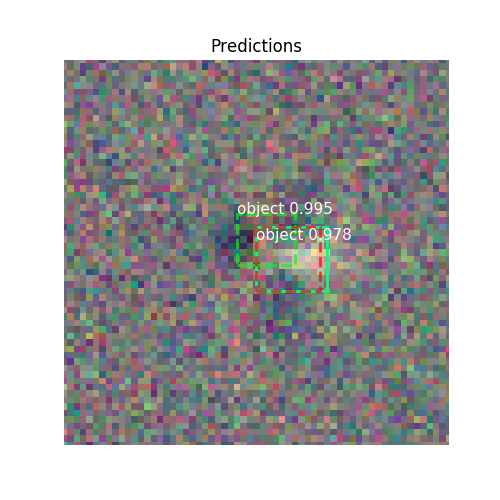

image ID: resid.3104 (3104) object


<IPython.core.display.Javascript object>


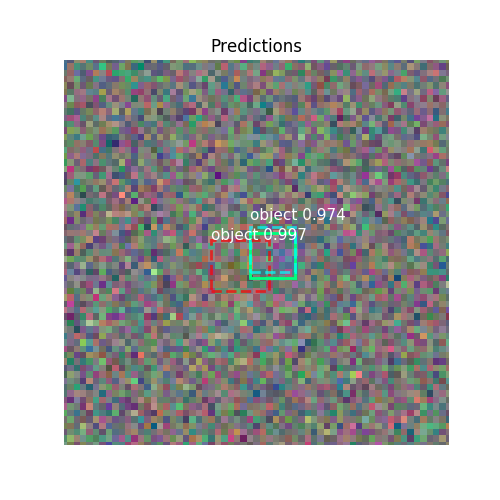

image ID: resid.1980 (1980) object


In [40]:
clss = 'iter_recog_both'
im_ids = np.random.choice(count[clss], 5)
for im_id in im_ids :
    ax = get_ax(1)
    image1, image_meta1, gt_class_id1, gt_bbox1 =\
        modellib.load_image_gt(dataset_val, inference_config, (im_id), use_mini_mask=False)
    info1 = dataset_val.image_info[im_id]
    results1 = model.detect([image1], verbose=0)
    r1 = results1[0]
    print("image ID: {}.{} ({}) {}".format(info1["source"], info1["id"], im_id, 
                                       dataset_val.image_reference(im_id)))
    visualize.draw_boxes(image1, boxes=gt_bbox1, refined_boxes=gt_bbox1, ax=ax, colors=['#00FF7F'])
    visualize.display_instances(image1, r1['rois'], r1['class_ids'], 
                                dataset_val.class_names, r1['scores'], ax=ax,
                                title="Predictions", limits=(34, 94))

<IPython.core.display.Javascript object>


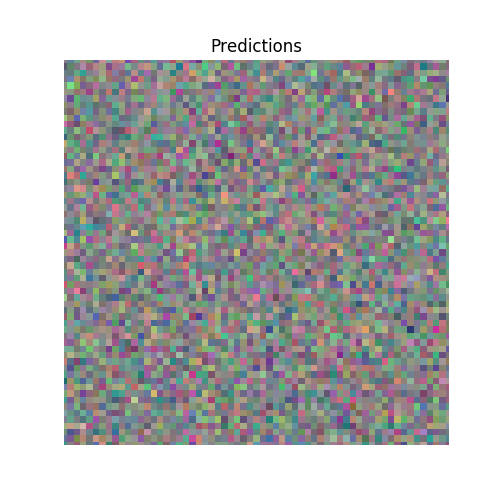

image ID: resid.4375 (4375) BG


<IPython.core.display.Javascript object>


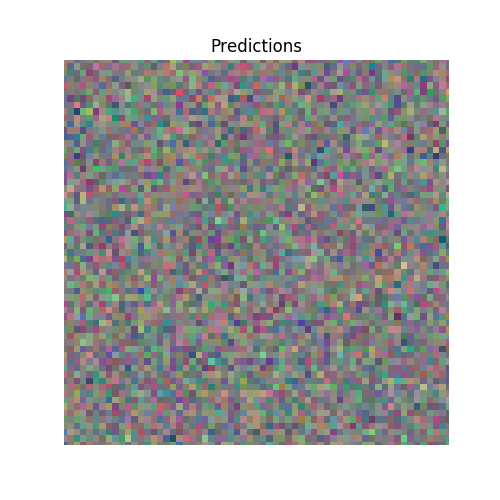

image ID: resid.4113 (4113) BG


<IPython.core.display.Javascript object>


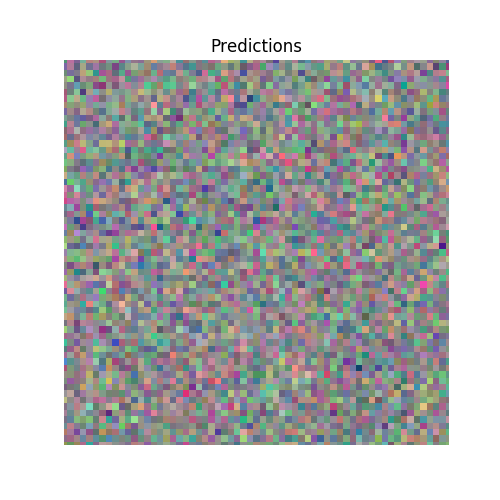

image ID: resid.4333 (4333) BG


<IPython.core.display.Javascript object>


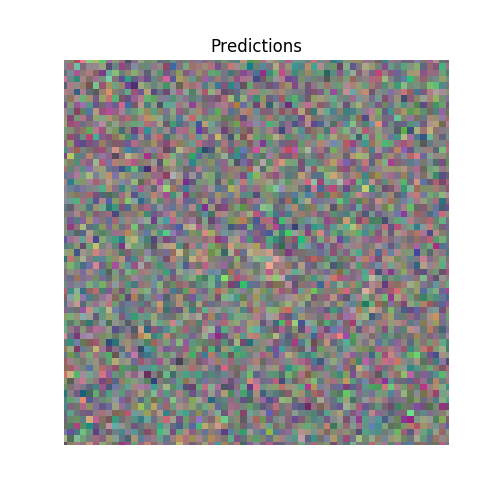

image ID: resid.4116 (4116) BG


<IPython.core.display.Javascript object>


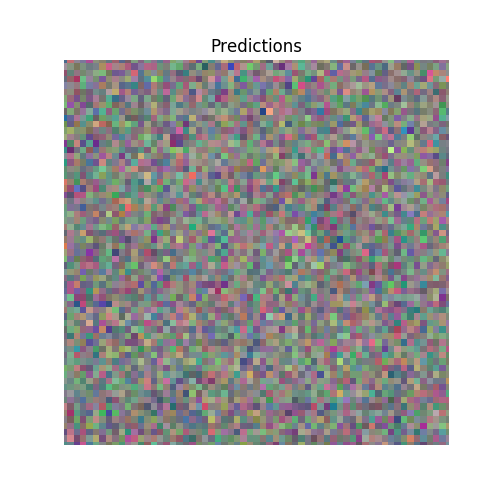

image ID: resid.4526 (4526) BG


In [41]:
clss = 'unrecog_blnd'
im_ids = np.random.choice(count[clss], 5)
for im_id in im_ids :
    ax = get_ax(1)
    image1, image_meta1, gt_class_id1, gt_bbox1 =\
        modellib.load_image_gt(dataset_val, inference_config, (im_id), use_mini_mask=False)
    info1 = dataset_val.image_info[im_id]
    results1 = model.detect([image1], verbose=0)
    r1 = results1[0]
    print("image ID: {}.{} ({}) {}".format(info1["source"], info1["id"], im_id, 
                                       dataset_val.image_reference(im_id)))
    visualize.draw_boxes(image1, boxes=gt_bbox1, refined_boxes=gt_bbox1, ax=ax, colors=['#00FF7F'])
    visualize.display_instances(image1, r1['rois'], r1['class_ids'], 
                                dataset_val.class_names, r1['scores'], ax=ax,
                                title="Predictions", limits=(34, 94))

<IPython.core.display.Javascript object>


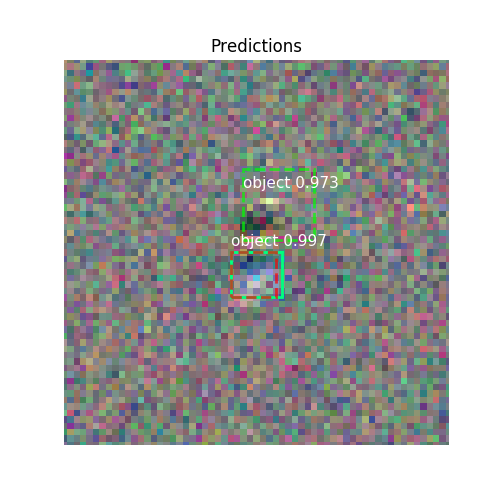

image ID: resid.3569 (3569) object


<IPython.core.display.Javascript object>


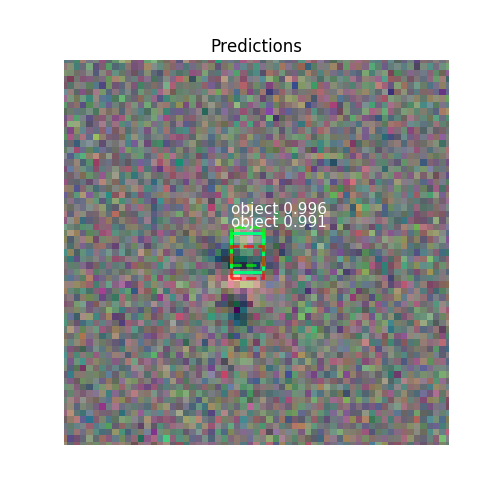

image ID: resid.1726 (1726) object


<IPython.core.display.Javascript object>


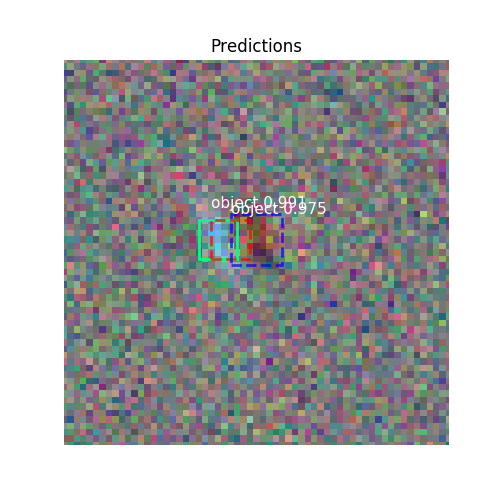

image ID: resid.1477 (1477) object


<IPython.core.display.Javascript object>


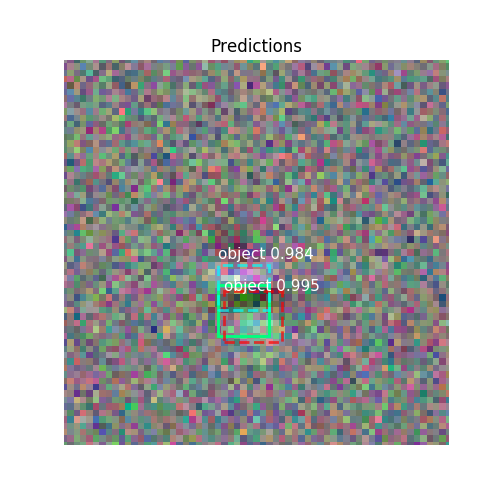

image ID: resid.1639 (1639) object


<IPython.core.display.Javascript object>


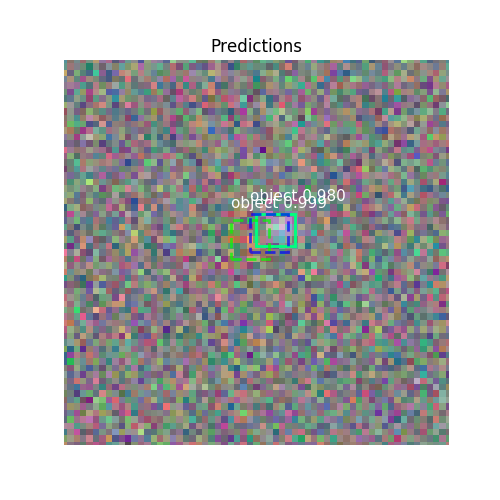

image ID: resid.152 (152) object


In [44]:
clss = 'iter_shred'
im_ids = np.random.choice(count[clss], 5)
for im_id in im_ids :
    ax = get_ax(1)
    image1, image_meta1, gt_class_id1, gt_bbox1 =\
        modellib.load_image_gt(dataset_val, inference_config, (im_id), use_mini_mask=False)
    info1 = dataset_val.image_info[im_id]
    results1 = model.detect([image1], verbose=0)
    r1 = results1[0]
    print("image ID: {}.{} ({}) {}".format(info1["source"], info1["id"], im_id, 
                                       dataset_val.image_reference(im_id)))
    visualize.draw_boxes(image1, boxes=gt_bbox1, refined_boxes=gt_bbox1, ax=ax, colors=['#00FF7F'])
    visualize.display_instances(image1, r1['rois'], r1['class_ids'], 
                                dataset_val.class_names, r1['scores'], ax=ax,
                                title="Predictions", limits=(34, 94))

<IPython.core.display.Javascript object>


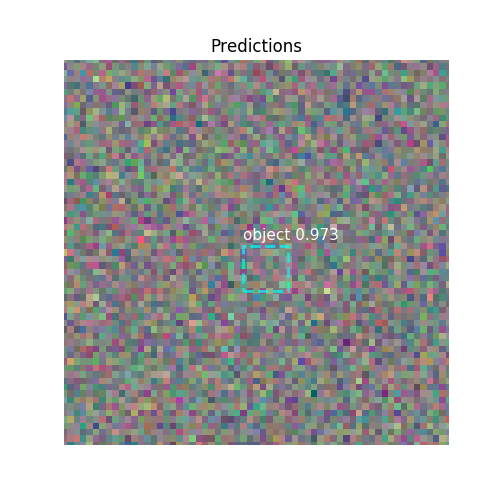

Processing 1 images
image                    shape: (128, 128, 12)        min:   -5.74434  max:    5.27528  float64
molded_images            shape: (1, 128, 128, 12)     min:   -5.74434  max:    5.27528  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 1364, 4)          min:    0.00000  max:    1.00000  float32
image ID: resid.4196 (4196) BG


<IPython.core.display.Javascript object>


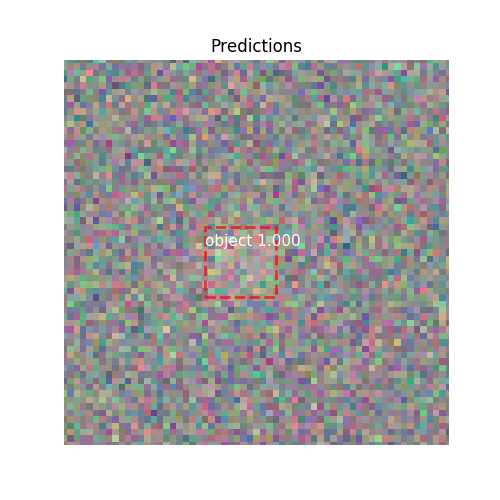

Processing 1 images
image                    shape: (128, 128, 12)        min:   -5.90053  max:    6.03699  float64
molded_images            shape: (1, 128, 128, 12)     min:   -5.90053  max:    6.03699  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 1364, 4)          min:    0.00000  max:    1.00000  float32
image ID: resid.4621 (4621) BG


<IPython.core.display.Javascript object>


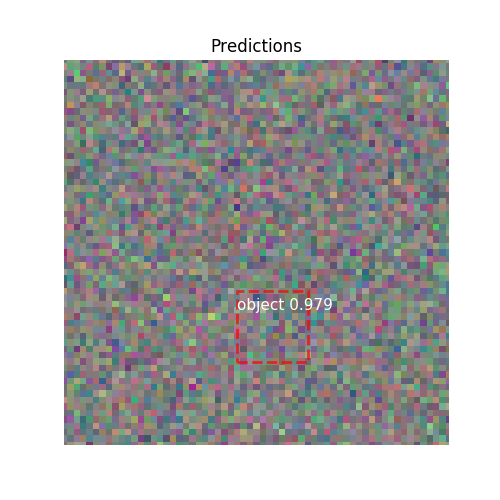

Processing 1 images
image                    shape: (128, 128, 12)        min:   -5.56653  max:    5.89282  float64
molded_images            shape: (1, 128, 128, 12)     min:   -5.56653  max:    5.89282  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 1364, 4)          min:    0.00000  max:    1.00000  float32
image ID: resid.4443 (4443) BG


<IPython.core.display.Javascript object>


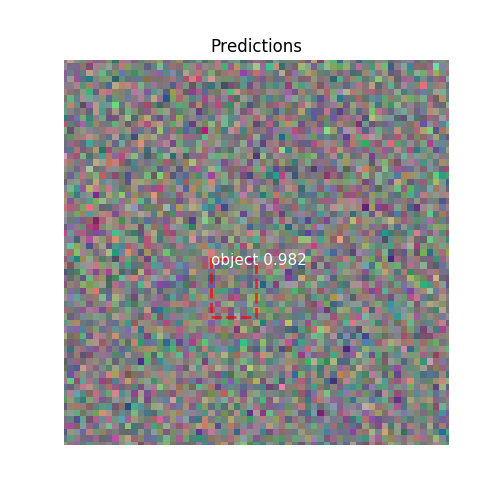

Processing 1 images
image                    shape: (128, 128, 12)        min:   -5.08595  max:    5.62369  float64
molded_images            shape: (1, 128, 128, 12)     min:   -5.08595  max:    5.62369  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 1364, 4)          min:    0.00000  max:    1.00000  float32
image ID: resid.4520 (4520) BG


<IPython.core.display.Javascript object>


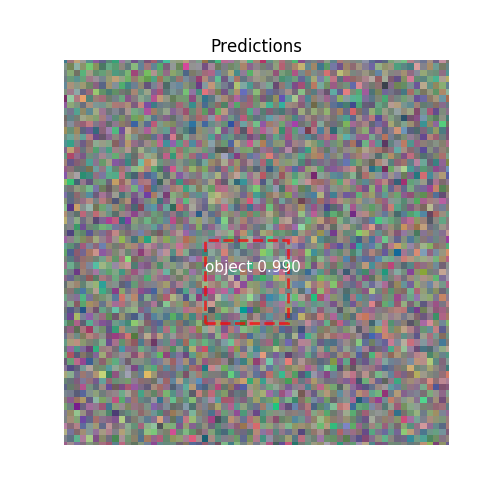

Processing 1 images
image                    shape: (128, 128, 12)        min:   -5.64102  max:    6.02738  float64
molded_images            shape: (1, 128, 128, 12)     min:   -5.64102  max:    6.02738  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 1364, 4)          min:    0.00000  max:    1.00000  float32
image ID: resid.4325 (4325) BG


In [46]:
clss = 'iter_spurious'
q, = np.where(results[clss] == 1)
select = results['id'][q].astype(int)
im_ids = np.random.choice(select, 5)
for im_id in im_ids :
    ax = get_ax(1)
    image1, image_meta1, gt_class_id1, gt_bbox1 =\
        modellib.load_image_gt(dataset_val, inference_config, (im_id), use_mini_mask=False)
    info1 = dataset_val.image_info[im_id]
    results1 = model.detect([image1], verbose=1)
    r1 = results1[0]
    print("image ID: {}.{} ({}) {}".format(info1["source"], info1["id"], im_id, 
                                       dataset_val.image_reference(im_id)))
    visualize.draw_boxes(image1, boxes=gt_bbox1, refined_boxes=gt_bbox1, ax=ax, colors=['#00FF7F'])
    visualize.display_instances(image1, r1['rois'], r1['class_ids'], 
                                dataset_val.class_names, r1['scores'], ax=ax,
                                title="Predictions", limits=(34, 94))